In [21]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
tqdm.pandas()
pd.options.display.max_columns = None

In [23]:
games = pd.read_csv('../data/games/games.csv', index_col = 0,
                   dtype = {'game_id' : np.int32, 'season' : np.int16, 'home_club_id' : np.int32, 'home_club_id' : np.int32,
                           'home_club_goals' : np.int8, 'away_club_goals' : np.int8})

appearance = pd.read_csv('../data/games/appearance.csv', index_col = 0)


In [22]:
train_df = pd.read_csv("../data/training_data/train_final.csv", index_col = 0)
train_df = train_df.astype(dtype={x:np.float16 for x in train_df.columns[1:-1]})



In [24]:
games.date = pd.to_datetime(games.date)

In [25]:
train_df.head(1)

,game_id,H_GK,H_GK_overall,H_GK_potential,H_GK_attacking_crossing,H_GK_attacking_heading_accuracy,H_GK_skill_curve,H_GK_skill_fk_accuracy,H_GK_movement_agility,H_GK_movement_reactions,H_GK_movement_balance,H_GK_power_shot_power,H_GK_power_jumping,H_GK_power_stamina,H_GK_mentality_aggression,H_GK_mentality_positioning,H_GK_mentality_penalties,H_GK_goalkeeping_diving,H_GK_goalkeeping_speed,H_attack,H_ATK_overall,H_ATK_potential,H_ATK_pace,H_ATK_shooting,H_ATK_passing,H_ATK_dribbling,H_ATK_defending,H_ATK_physic,H_ATK_attacking_crossing,H_ATK_attacking_heading_accuracy,H_ATK_skill_curve,H_ATK_skill_fk_accuracy,H_ATK_movement_agility,H_ATK_movement_reactions,H_ATK_movement_balance,H_ATK_power_shot_power,H_ATK_power_jumping,H_ATK_power_stamina,H_ATK_mentality_aggression,H_ATK_mentality_positioning,H_ATK_mentality_penalties,H_ATK_mentality_composure,H_defense,H_DEF_overall,H_DEF_potential,H_DEF_pace,H_DEF_shooting,H_DEF_passing,H_DEF_dribbling,H_DEF_defending,H_DEF_physic,H_DEF_attacking_crossing,H_DEF_attacking_heading_accuracy,H_DEF_skill_curve,H_DEF_skill_fk_accuracy,H_DEF_movement_agility,H_DEF_movement_reactions,H_DEF_movement_balance,H_DEF_power_shot_power,H_DEF_power_jumping,H_DEF_power_stamina,H_DEF_mentality_aggression,H_DEF_mentality_positioning,H_DEF_mentality_penalties,H_DEF_mentality_composure,H_midfield,H_MF_overall,H_MF_potential,H_MF_pace,H_MF_shooting,H_MF_passing,H_MF_dribbling,H_MF_defending,H_MF_physic,H_MF_attacking_crossing,H_MF_attacking_heading_accuracy,H_MF_skill_curve,H_MF_skill_fk_accuracy,H_MF_movement_agility,H_MF_movement_reactions,H_MF_movement_balance,H_MF_power_shot_power,H_MF_power_jumping,H_MF_power_stamina,H_MF_mentality_aggression,H_MF_mentality_positioning,H_MF_mentality_penalties,H_MF_mentality_composure,A_GK,A_GK_overall,A_GK_potential,A_GK_attacking_crossing,A_GK_attacking_heading_accuracy,A_GK_skill_curve,A_GK_skill_fk_accuracy,A_GK_movement_agility,A_GK_movement_reactions,A_GK_movement_balance,A_GK_power_shot_power,A_GK_power_jumping,A_GK_power_stamina,A_GK_mentality_aggression,A_GK_mentality_positioning,A_GK_mentality_penalties,A_GK_goalkeeping_diving,A_GK_goalkeeping_speed,A_attack,A_ATK_overall,A_ATK_potential,A_ATK_pace,A_ATK_shooting,A_ATK_passing,A_ATK_dribbling,A_ATK_defending,A_ATK_physic,A_ATK_attacking_crossing,A_ATK_attacking_heading_accuracy,A_ATK_skill_curve,A_ATK_skill_fk_accuracy,A_ATK_movement_agility,A_ATK_movement_reactions,A_ATK_movement_balance,A_ATK_power_shot_power,A_ATK_power_jumping,A_ATK_power_stamina,A_ATK_mentality_aggression,A_ATK_mentality_positioning,A_ATK_mentality_penalties,A_ATK_mentality_composure,A_defense,A_DEF_overall,A_DEF_potential,A_DEF_pace,A_DEF_shooting,A_DEF_passing,A_DEF_dribbling,A_DEF_defending,A_DEF_physic,A_DEF_attacking_crossing,A_DEF_attacking_heading_accuracy,A_DEF_skill_curve,A_DEF_skill_fk_accuracy,A_DEF_movement_agility,A_DEF_movement_reactions,A_DEF_movement_balance,A_DEF_power_shot_power,A_DEF_power_jumping,A_DEF_power_stamina,A_DEF_mentality_aggression,A_DEF_mentality_positioning,A_DEF_mentality_penalties,A_DEF_mentality_composure,A_midfield,A_MF_overall,A_MF_potential,A_MF_pace,A_MF_shooting,A_MF_passing,A_MF_dribbling,A_MF_defending,A_MF_physic,A_MF_attacking_crossing,A_MF_attacking_heading_accuracy,A_MF_skill_curve,A_MF_skill_fk_accuracy,A_MF_movement_agility,A_MF_movement_reactions,A_MF_movement_balance,A_MF_power_shot_power,A_MF_power_jumping,A_MF_power_stamina,A_MF_mentality_aggression,A_MF_mentality_positioning,A_MF_mentality_penalties,A_MF_mentality_composure,Home_result
0,2457642,1.0,70.0,70.0,25.0,25.0,25.0,25.0,36.0,65.0,41.0,27.0,45.0,40.0,30.0,25.0,45.0,68.0,38.0,0.555664,63.53125,73.4375,72.75,59.84375,57.25,65.3125,26.984375,61.21875,61.0,57.1875,53.90625,34.75,64.1875,47.46875,60.71875,66.9375,53.1875,68.0625,64.875,58.28125,62.1875,0.0,4.0,65.75,68.0,62.0,51.5,59.75,63.0,66.0,68.0,50.5,61.75,61.25,52.0,58.75,64.0,64.5,62.5,64.75,68.5,59.25,53.5,64.25,0.0,5.445312,69.1875,74.75,71.4375,59.09375,65.375,71.125,49.125,61

In [26]:
games.drop(columns = ['competition_code', 'season', 'round','home_club_position', 'away_club_position', 'stadium', 'attendance',
       'referee', 'url'], inplace = True)
       
appearance.drop(columns = ['player_id','appearance_id', 'competition_id', 'goals', 'assists', 'minutes_played'], inplace = True)

In [27]:
appearance = appearance.astype(dtype={ 'player_club_id':np.int32, 'yellow_cards':np.int8, 'red_cards':np.int8})

In [29]:
games.head(1)

,game_id,date,home_club_id,away_club_id,home_club_goals,away_club_goals
0,2457642,2014-08-03,1269,610,1,0


In [30]:
games['results'] = games.progress_apply(lambda x: 'W' if x['home_club_goals']>x['away_club_goals'] else \
    ('L' if x['home_club_goals']<x['away_club_goals'] else 'D')
    , axis = 1)

100%|██████████| 42592/42592 [00:01<00:00, 33754.34it/s]


In [18]:
def get_home_history(game_id):
    N = 5   #how many games we are looking for in club's history
    
    target_game = games.loc[games.game_id == game_id,:]
    N_last_games = games.loc[((games.home_club_id == target_game['home_club_id'].values[0]) | (games.away_club_id == target_game['home_club_id'].values[0]))\
        & (games.date < target_game['date'].values[0]) ,:].sort_values('date',ascending=False)[:N]
        
    last_results = N_last_games.results.value_counts()
    try:
        wins = last_results['W']
    except:
        wins = 0
    try:
        draws = last_results['D']
    except:
        draws = 0
    try:
        loss = last_results['L']
    except:
        loss = 0

    goal_scored = N_last_games.loc[N_last_games.home_club_id == target_game['home_club_id'].values[0],'home_club_goals'].sum()\
        + N_last_games.loc[N_last_games.away_club_id == target_game['home_club_id'].values[0],'away_club_goals'].sum()

    goals_conceded = N_last_games.loc[N_last_games.home_club_id == target_game['home_club_id'].values[0],'away_club_goals'].sum()\
        + N_last_games.loc[N_last_games.away_club_id == target_game['home_club_id'].values[0],'home_club_goals'].sum()

    cards = appearance.loc[(appearance.game_id.isin(N_last_games.game_id.values)) \
        & (appearance.player_club_id == target_game['home_club_id'].values[0]),\
            ['yellow_cards','red_cards']].sum()
    
    res = {'H_wins': wins, 'H_draws': draws , 'H_loss': loss,\
        'H_goal_scored': goal_scored, 'H_goals_conceded' : goals_conceded, 'H_yellow_cards' : cards['yellow_cards'], 'H_red_cards' : cards['red_cards']}
    
    return pd.Series(res)
    
    


In [19]:
def get_away_history(game_id):
    N=5
    target_game = games.loc[games.game_id == game_id,:]
    target_club = target_game['away_club_id'].values[0]
    N_last_games = games.loc[((games.home_club_id == target_club) | (games.away_club_id == target_club))\
        & (games.date < target_game['date'].values[0]) ,:].sort_values('date',ascending=False)[:N]
        
    last_results = N_last_games.results.value_counts()
    try:
        wins = last_results['W']
    except:
        wins = 0
    try:
        draws = last_results['D']
    except:
        draws = 0
    try:
        loss = last_results['L']
    except:
        loss = 0

    goal_scored = N_last_games.loc[N_last_games.home_club_id == target_club,'home_club_goals'].sum()\
        + N_last_games.loc[N_last_games.away_club_id == target_club,'away_club_goals'].sum()

    goals_conceded = N_last_games.loc[N_last_games.home_club_id == target_club,'away_club_goals'].sum()\
        + N_last_games.loc[N_last_games.away_club_id == target_club,'home_club_goals'].sum()

    cards = appearance.loc[(appearance.game_id.isin(N_last_games.game_id.values)) \
        & (appearance.player_club_id == target_club),\
            ['yellow_cards','red_cards']].sum()
    
    res = {'A_wins': wins, 'A_draws': draws , 'A_loss': loss,\
        'A_goal_scored': goal_scored, 'A_goals_conceded' : goals_conceded, 'A_yellow_cards' : cards['yellow_cards'], 'A_red_cards' : cards['red_cards']}
    
    return pd.Series(res)
    
    


In [31]:
home_features = train_df.game_id.progress_apply(get_home_history)

100%|██████████| 29545/29545 [12:35<00:00, 39.12it/s]


In [32]:
away_features = train_df.game_id.progress_apply(get_away_history)

100%|██████████| 29545/29545 [12:31<00:00, 39.30it/s]


In [33]:
home_features = home_features.astype(dtype={'H_wins':np.int8, 'H_draws':np.int8, 'H_loss':np.int8, 'H_goal_scored':np.int8, 'H_goals_conceded':np.int8,
       'H_yellow_cards':np.int8, 'H_red_cards':np.int8})
away_features = away_features.astype(dtype={'A_wins':np.int8, 'A_draws':np.int8, 'A_loss':np.int8, 'A_goal_scored':np.int8, 'A_goals_conceded':np.int8,
       'A_yellow_cards':np.int8, 'A_red_cards':np.int8})

In [34]:
away_features.shape, train_df.shape

((29545, 7), (29545, 176))

In [35]:
train_more_features = pd.concat([home_features,away_features,train_df],axis =1)

In [36]:
train_more_features.to_csv('../data/training_data/train_more_features5.csv')

# model training

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
import pickle

In [39]:
def cm_metrics(true_label,pred_label, labels_):
  cm = confusion_matrix(true_label,pred_label,labels = labels_)
  cmDisp = ConfusionMatrixDisplay(cm,display_labels=labels_)
  recall = { i:cm[i][i]/cm[i].sum()  for i in range(len(cm))}
  precision = { i:cm[i][i]/cm[:,i].sum()  for i in range(len(cm))}
  F1_score = { i: 2 / (1/recall[i] + 1/precision[i]) for i in range(len(cm))}
  accuracy = (cm[0][0]+cm[1][1]+cm[2][2])/cm.sum()
  print('accuracy: ', accuracy)
  print('Recall: \n',recall,'\nPrecision: \n', precision,'\nF1-score: \n',F1_score)
  cmDisp.plot()
  plt.show()
  return None

In [57]:
train_df = pd.read_csv('../data/training_data/train_more_features5.csv', index_col=0)

In [58]:
train_df.drop(columns = ['game_id'], inplace = True)
train_df = train_df.astype(dtype={x:np.int8 for x in train_df.columns[:14]})
train_df = train_df.astype(dtype={x:np.float16 for x in train_df.columns[14:-1]})

##### normalisation

In [59]:
col_select = ['H_GK', 'H_attack', 'H_defense', 'H_midfield','A_GK', 'A_attack', 'A_defense', 'A_midfield']
train_df.loc[:,col_select]=train_df.loc[:,col_select]/5


In [60]:
col_select = np.append(col_select ,train_df.columns[:14])
col_select = np.append(col_select ,['Home_result'])
col_mask = [x  for x in train_df.columns if (x not in col_select)]
train_df.loc[:,col_mask]=train_df.loc[:,col_mask]/100


In [61]:
train_df.H_yellow_cards = train_df.H_yellow_cards/10
train_df.A_yellow_cards = train_df.A_yellow_cards/10
train_df[['H_goal_scored','H_goals_conceded','A_goal_scored','A_goals_conceded']]= \
    train_df[['H_goal_scored','H_goals_conceded','A_goal_scored','A_goals_conceded']]/7

### transformation de la target
0 = HomeWin   
1 = Draw   
2 = AwayWin

In [80]:
train_df.Home_result=train_df.Home_result.apply(lambda x: np.int8(0) if x>0 else (np.int8(2) if x<0 else np.int8(1)))

### Préparation des données pour l'entrainement

In [82]:
X = train_df.loc[:,train_df.columns[:-1]]
y = train_df.Home_result

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state=0, stratify=y)

In [102]:
MLPC = MLPClassifier(solver='lbfgs', alpha=0.001, learning_rate_init=0.0001, max_iter=500)

In [ ]:
MLPC = MLPClassifier(solver='adam', alpha=0.001, learning_rate='adaptative', max_iter=500)

In [103]:
MLPC.fit(X_train, y_train)

/Users/pierreadda/opt/anaconda3/envs/foot_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=0.001, learning_rate_init=0.0001, max_iter=500,
              solver='lbfgs')

In [104]:
y_train_pred = MLPC.predict(X_train)
y_test_pred = MLPC.predict(X_test)

accuracy:  0.5605650329452116
Recall: 
 {0: 0.7799879445449066, 1: 0.14473684210526316, 2: 0.5693301997649823} 
Precision: 
 {0: 0.5920841912605811, 1: 0.43729003359462487, 2: 0.5339578454332553} 
F1-score: 
 {0: 0.6731694628690338, 1: 0.2174881648565859, 2: 0.5510769886969502}


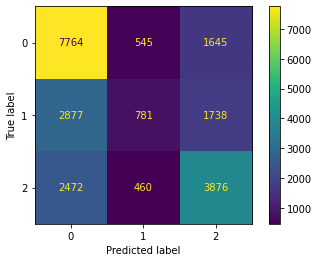

In [105]:
cm_metrics(y_train,y_train_pred,MLPC.classes_)

accuracy:  0.5119805062948423
Recall: 
 {0: 0.73214823742091, 1: 0.09171762090050027, 2: 0.5231379462318202} 
Precision: 
 {0: 0.5626302384811299, 1: 0.26484751203852325, 2: 0.485480572597137} 
F1-score: 
 {0: 0.6362922230950511, 1: 0.13625103220478943, 2: 0.5036062791684345}


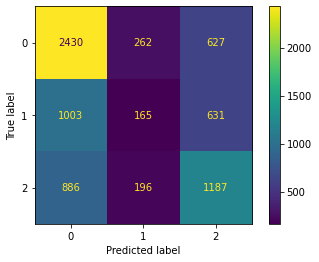

In [106]:
cm_metrics(y_test,y_test_pred,MLPC.classes_)

In [107]:
MLPC.estimator.loss_curve_

AttributeError: 'MLPClassifier' object has no attribute 'estimator'